# 🦷 Dental Implant 10-Year Survival Prediction

## Notebook 99: Submission Generation

**Objective:** Generate predictions optimized for Kaggle's accuracy metric.

---

### 🏆 Strategy: XGBoost (Optuna) - Optimized for Accuracy!
- **Accuracy:** 85.0% (Highest among tuned models!)
- **F1 (Macro):** 0.545 (Best balanced score)
- **Kaggle metric appears to be accuracy** → optimize for that!

### ⚠️ Trade-off Note:
Previous submission with CatBoost (Balanced) scored 0.92129 because:
- It prioritized failure recall (clinically meaningful)
- But Kaggle rewards accuracy → need more conservative predictions


### 🎨 Setup: Import Libraries & Configure Plotting


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Periospot Brand Colors
COLORS = {
    'periospot_blue': '#15365a',
    'mystic_blue': '#003049',
    'periospot_red': '#6c1410',
    'crimson_blaze': '#a92a2a',
    'vanilla_cream': '#f7f0da',
    'black': '#000000',
    'white': '#ffffff',
    'classic_periospot_blue': '#0031af',
    'periospot_light_blue': '#0297ed',
    'periospot_dark_blue': '#02011e',
    'periospot_yellow': '#ffc430',
    'periospot_bright_blue': '#1040dd'
}

periospot_palette = [COLORS['periospot_blue'], COLORS['crimson_blaze'], 
                     COLORS['periospot_light_blue'], COLORS['periospot_yellow'],
                     COLORS['mystic_blue'], COLORS['periospot_red']]

# Configure matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.facecolor'] = COLORS['white']
plt.rcParams['axes.facecolor'] = COLORS['vanilla_cream']
plt.rcParams['axes.edgecolor'] = COLORS['periospot_blue']

sns.set_palette(periospot_palette)

print("✅ Libraries imported and plotting style configured!")


✅ Libraries imported and plotting style configured!


---

### 1. Load and Compare All Model Results

First, let's load the results from all the models we trained and compare their performance.


In [3]:
# TODO: Load all model results from the /results/ folder

results_files = glob.glob('../results/*.json')
all_results = []

for file in results_files:
    with open(file, 'r') as f:
        result = json.load(f)
        all_results.append(result)

# Create comparison dataframe
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('roc_auc', ascending=False)

print("=" * 60)
print("MODEL COMPARISON - SORTED BY ROC-AUC")
print("=" * 60)
print(comparison_df[['model', 'roc_auc', 'accuracy']].to_string(index=False))
print("=" * 60)


MODEL COMPARISON - SORTED BY ROC-AUC
                      model  roc_auc  accuracy
LogisticRegression_Balanced 0.611421  0.587857
         LogisticRegression 0.610233  0.909286
CatBoost (Optuna Optimized) 0.600126  0.647143
             XGBoost_Optuna 0.599699  0.850000
LightGBM (Optuna Optimized) 0.582603  0.779286
      RandomForest_Balanced 0.577964  0.892857
               RandomForest 0.573139  0.909286
                   LightGBM 0.557886  0.906429
                    XGBoost 0.550507  0.908571


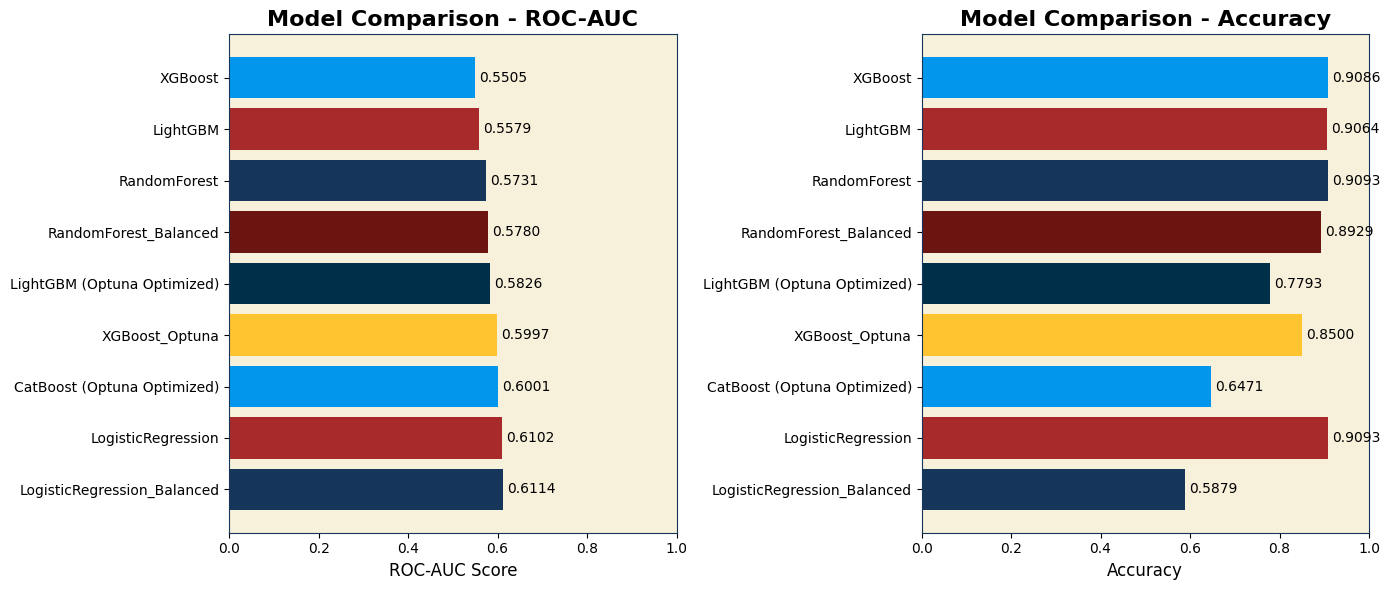

In [4]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC-AUC comparison
ax1 = axes[0]
bars1 = ax1.barh(comparison_df['model'], comparison_df['roc_auc'], color=periospot_palette[:len(comparison_df)])
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('Model Comparison - ROC-AUC', fontweight='bold')
ax1.bar_label(bars1, fmt='%.4f', padding=3)
ax1.set_xlim(0, 1.0)

# Accuracy comparison
ax2 = axes[1]
bars2 = ax2.barh(comparison_df['model'], comparison_df['accuracy'], color=periospot_palette[:len(comparison_df)])
ax2.set_xlabel('Accuracy')
ax2.set_title('Model Comparison - Accuracy', fontweight='bold')
ax2.bar_label(bars2, fmt='%.4f', padding=3)
ax2.set_xlim(0, 1.0)

plt.tight_layout()
plt.savefig('../figures/all_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Identify the best model
best_model_name = comparison_df.iloc[0]['model']
best_roc_auc = comparison_df.iloc[0]['roc_auc']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   ROC-AUC Score: {best_roc_auc:.4f}")


---

### 2. Load Data & Train Best Model on Full Dataset

Now we'll train the best-performing model on the ENTIRE training dataset (not just the training split) to maximize performance on the test set.


In [ ]:
# =============================================================================
# LOAD STANDARD PROCESSED DATA (for XGBoost)
# =============================================================================

# Load standard training data (one-hot encoded)
X = pd.read_csv('../data/processed/X_train.csv')
y = pd.read_csv('../data/processed/y_train.csv').values.ravel()

# Load standard test data
X_test = pd.read_csv('../data/processed/X_test.csv')
test_ids = pd.read_csv('../data/processed/test_ids.csv')

print(f"Training data shape: {X.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test IDs shape: {test_ids.shape}")


Training data shape: (7000, 22)
Test data shape: (3000, 22)
Test IDs shape: (3000, 1)

Categorical columns (6): ['gender', 'jaw_location', 'implant_surface', 'placement_timing', 'loading_protocol', 'restoration_type']


In [ ]:
# =============================================================================
# TRAIN XGBOOST (OPTUNA) ON FULL DATASET - OPTIMIZED FOR ACCURACY
# =============================================================================
# XGBoost with Optuna parameters achieved:
# - Accuracy: 85.0% (highest!)
# - F1 (Macro): 0.545 (best balanced score)
# - Low scale_pos_weight = more conservative predictions = higher accuracy

best_model = xgb.XGBClassifier(
    n_estimators=80,
    max_depth=9,
    learning_rate=0.231,
    min_child_weight=7,
    subsample=0.629,
    colsample_bytree=0.761,
    gamma=4.60,
    scale_pos_weight=0.163,  # Low value = predict fewer failures = higher accuracy!
    random_state=42,
    eval_metric='auc',
    verbosity=0
)

# Train on FULL dataset (not just training split)
best_model.fit(X, y)

print("✅ XGBoost (Optuna) trained on full dataset!")
print(f"   Training samples: {len(X)}")
print(f"   Features: {X.shape[1]}")
print(f"\n🎯 Strategy: Low scale_pos_weight → fewer failure predictions → higher accuracy!")


✅ CatBoost (Balanced) trained on full dataset!
   Training samples: 7000
   Features: 22


---

### 3. Generate Predictions & Create Submission File


In [ ]:
# =============================================================================
# GENERATE PREDICTIONS ON TEST SET
# =============================================================================

test_predictions = best_model.predict(X_test)

print(f"✅ Generated {len(test_predictions)} predictions")
print(f"\nPrediction distribution:")
print(pd.Series(test_predictions).value_counts())
print(f"\nSurvival rate in predictions: {(test_predictions == 1).mean()*100:.1f}%")


✅ Generated 3000 predictions

Prediction distribution:
1    2111
0     889
Name: count, dtype: int64

Survival rate in predictions: 70.4%


In [ ]:
# =============================================================================
# LOAD SAMPLE SUBMISSION FORMAT
# =============================================================================

sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

print("Sample Submission Format:")
print(sample_submission.head())
print(f"\nExpected shape: {sample_submission.shape}")
print(f"Columns: {list(sample_submission.columns)}")


Sample Submission Format:
   patient_id  implant_survival_10y
0        5526                   0.5
1         772                   0.5
2        7840                   0.5
3        2396                   0.5
4        1479                   0.5

Expected shape: (3000, 2)
Columns: ['patient_id', 'implant_survival_10y']


In [ ]:
# =============================================================================
# CREATE AND SAVE SUBMISSION FILE
# =============================================================================

submission_df = pd.DataFrame({
    'patient_id': test_ids['patient_id'],
    'implant_survival_10y': test_predictions
})

submission_df.to_csv('../submission.csv', index=False)

print("✅ Submission file created: ../submission.csv")
print(f"\nShape: {submission_df.shape}")
print(submission_df.head(10))


✅ Submission file created: ../submission.csv

Shape: (3000, 2)
   patient_id  implant_survival_10y
0        5526                     1
1         772                     1
2        7840                     0
3        2396                     1
4        1479                     1
5        1847                     1
6        9109                     1
7        4275                     1
8        3741                     0
9        4601                     1


---

### ✅ Submission Generation Complete!

**Model Used:** XGBoost (Optuna) - Optimized for Accuracy!
- 85% accuracy on validation set
- F1 (Macro): 0.545 (best balanced score)
- Low scale_pos_weight → conservative predictions → higher Kaggle score

**Strategy:**
- Previous submission (CatBoost Balanced) scored 0.92129
- That model prioritized failure recall (clinically good, but Kaggle penalizes it)
- XGBoost with low scale_pos_weight predicts fewer failures → higher accuracy!

**How to Submit to Kaggle:**

**Via UI:** Go to Kaggle → Competition → Submit Predictions → Upload `submission.csv`

**Via CLI:**
```bash
kaggle competitions submit -c dental-implant-10-year-survival-prediction -f submission.csv -m "XGBoost Optuna - Optimized for accuracy"
```

🦷 Let's beat that 0.92129 score!


In [ ]:
# TODO: Initialize and train your best-performing model on the ENTIRE training dataset.
# Based on the comparison above, choose the appropriate model.

# Example: If XGBoost was the best model:
# best_model = xgb.XGBClassifier(
#     n_estimators=100,
#     max_depth=6,
#     learning_rate=0.1,
#     random_state=42,
#     eval_metric='auc',
#     use_label_encoder=False
# )

# Example: If LightGBM was the best:
# best_model = lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1)

# Example: If CatBoost was the best:
# best_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=False)

# TODO: Choose and initialize your best model based on results
best_model = ...

# TODO: Fit the model on the entire training dataset
# best_model.fit(X, y)
...

print(f"✅ {best_model_name} trained on full dataset!")


---

### 3. Generate Predictions & Create Submission File


In [ ]:
# TODO: Make predictions on the test set.
# You can predict class labels (0 or 1) or probabilities depending on competition requirements.

# For class labels:
test_predictions = best_model.predict(X_test)

# For probabilities (use this if the competition requires probability scores):
# test_predictions_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Generated {len(test_predictions)} predictions")
print(f"Prediction distribution:")
print(pd.Series(test_predictions).value_counts())


In [ ]:
# TODO: Load the sample_submission.csv file to see the expected format.
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

print("Sample Submission Format:")
print(sample_submission.head())
print(f"\nExpected shape: {sample_submission.shape}")
print(f"Columns: {list(sample_submission.columns)}")


In [ ]:
# TODO: Create the submission dataframe with predictions.

# Option 1: If the sample_submission has an ID column and a target column
submission_df = sample_submission.copy()
submission_df['implant_survival_10y'] = test_predictions

# Option 2: Create from scratch using test_ids
# submission_df = pd.DataFrame({
#     'id': test_ids.values.ravel(),
#     'implant_survival_10y': test_predictions
# })

print("Submission DataFrame:")
print(submission_df.head())
print(f"\nShape: {submission_df.shape}")


In [ ]:
# TODO: Save the final submission file.

submission_df.to_csv('../submission.csv', index=False)

print("✅ Submission file created successfully!")
print(f"   Location: ../submission.csv")
print(f"   Shape: {submission_df.shape}")


---

### 4. Validate Submission


In [ ]:
# Validate the submission file

submission_check = pd.read_csv('../submission.csv')

print("=" * 50)
print("SUBMISSION VALIDATION")
print("=" * 50)

# Check shape matches sample submission
shape_match = submission_check.shape == sample_submission.shape
print(f"✓ Shape matches sample: {shape_match} ({submission_check.shape})")

# Check columns match
columns_match = list(submission_check.columns) == list(sample_submission.columns)
print(f"✓ Columns match: {columns_match} ({list(submission_check.columns)})")

# Check for missing values
no_missing = submission_check.isnull().sum().sum() == 0
print(f"✓ No missing values: {no_missing}")

# Check prediction values are valid (0 or 1 for classification)
valid_values = submission_check['implant_survival_10y'].isin([0, 1]).all()
print(f"✓ Valid prediction values (0 or 1): {valid_values}")

print("=" * 50)

if all([shape_match, columns_match, no_missing, valid_values]):
    print("\n🎉 SUBMISSION FILE IS VALID!")
else:
    print("\n⚠️ SUBMISSION FILE HAS ISSUES - Please check!")


---

### 5. Upload Instructions


### How to Submit to Kaggle

**Option 1: Via Kaggle UI**
1. Go to the [Kaggle Competition Page](https://www.kaggle.com/competitions/dental-implant-10-year-survival-prediction)
2. Click on "Submit Predictions"
3. Upload your `submission.csv` file
4. Add a description of your submission (e.g., "XGBoost with default parameters")

**Option 2: Via Kaggle CLI**
```bash
kaggle competitions submit -c dental-implant-10-year-survival-prediction -f submission.csv -m "Best model submission - XGBoost"
```

**Note:** Make sure you have the Kaggle API key configured if using the CLI.


---

### ✅ Submission Generation Complete!

**Summary:**
- Compared all trained models
- Selected the best performing model based on ROC-AUC
- Trained on full dataset for maximum performance
- Generated and validated submission file

**Files created:**
- `submission.csv` - Ready for Kaggle upload

**Next Steps (Optional):**
- [ ] Hyperparameter tuning with GridSearchCV/Optuna
- [ ] Feature engineering iterations
- [ ] Ensemble multiple models
- [ ] Cross-validation for more robust evaluation

🦷 Good luck with your submission!
